In [1]:
# https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/simulated.ipynb

import os
import sys

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv
import scanpy as sc

In [2]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [3]:
def get_adata(n_obs, mu, R, C, n_vars=1000):
    cov = C.dot(C.T) * R

    alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
    beta /= 3
    gamma /= 3

    # remove outliers
    idx = (alpha < np.percentile(alpha, 99)) & (beta < np.percentile(beta, 99)) & (gamma < np.percentile(gamma, 99))
    alpha = alpha[idx]
    beta = beta[idx]
    gamma = gamma[idx]
    n_vars = np.sum(idx)

    switches = np.random.uniform(.1, .5, size=n_vars)

    adata = scv.datasets.simulation(
        n_obs=n_obs,
        t_max=20,
        n_vars=n_vars,
        switches=switches,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        noise_level=.8
    )

    scv.pp.neighbors(adata)
    
    return adata

In [4]:
correlation_df = pd.DataFrame(columns=['correlation', 'method', 'n_obs', 'run'])

adatas = {}
bdatas = {}

mu = np.array([1, .2, .05])

R = np.array([[1., .2, .2],
              [.2, 1., .8],
              [.2, .8, 1.]])

C = np.array([.4, .4, .4])[:, None]
n_obs = 5000

In [5]:
np.random.seed(12232024)
adata = get_adata(n_obs=n_obs, mu=mu, R=R, C=C)
sc.tl.umap(adata)

adata2 = adata.copy()

computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [6]:
scv.tl.velocity(adata, mode='steady_state', use_raw=True)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
adata

AnnData object with n_obs × n_vars = 5000 × 975
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'velocity'
    obsp: 'distances', 'connectivities'

In [8]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


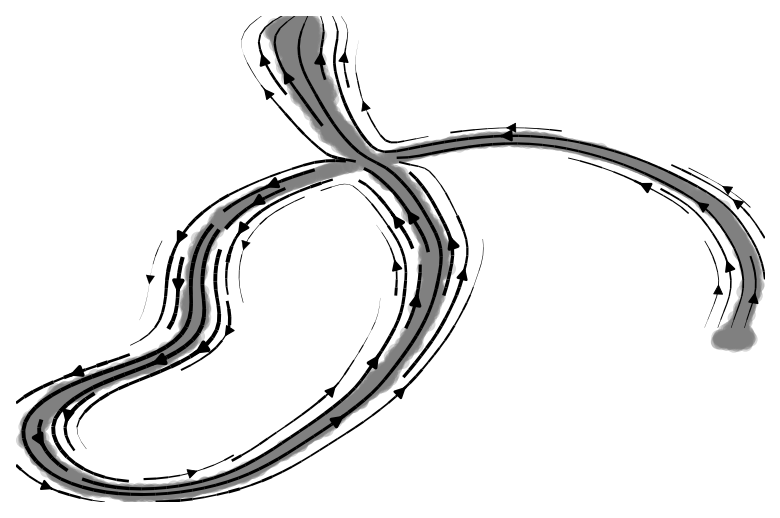

In [9]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

# Steady-state model

In [10]:
run_id = 1
adata.var['true_ratio'] = np.array(adata.var['true_gamma'] / adata.var['true_beta'])
adata.var['steady_state_ratio'] = adata.var['velocity_gamma']
corr = pearsonr(adata.var['true_ratio'], adata.var['steady_state_ratio'])[0]
# Create a new DataFrame for the row you want to append
new_row = pd.DataFrame([{'correlation': corr, 'method': 'Steady-state', 'n_obs': n_obs, 'run': run_id}])
# Concatenate the new row to the existing DataFrame
correlation_df = pd.concat([correlation_df, new_row], ignore_index=True)

# EM model

In [11]:
adata2

AnnData object with n_obs × n_vars = 5000 × 975
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced'
    obsp: 'distances', 'connectivities'

In [12]:
scv.tl.recover_dynamics(
    adata2, var_names=adata2.var_names, use_raw=True, n_jobs=8
)

recovering dynamics (using 8/20 cores)
    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [13]:
adata2.var['true_ratio'] = np.array(adata2.var['true_gamma'] / adata2.var['true_beta'])
adata2.var['em_ratio'] = adata2.var['fit_gamma'] / adata2.var['fit_beta']
corr = pearsonr(adata2.var['true_ratio'], adata2.var['em_ratio'])[0]
# Create a new DataFrame for the row you want to append
new_row = pd.DataFrame([{'correlation': corr, 'method': 'EM', 'n_obs': n_obs, 'run': run_id}])
# Concatenate the new row to the existing DataFrame
correlation_df = pd.concat([correlation_df, new_row], ignore_index=True)

In [14]:
scv.tl.velocity_graph(adata2)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/home/users/kzlin/miniconda3/envs/scVelo_developer/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
adata2

AnnData object with n_obs × n_vars = 5000 × 975
    obs: 'true_t', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'true_ratio', 'em_ratio', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'fit_t', 'fit_tau', 'fit_tau_', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


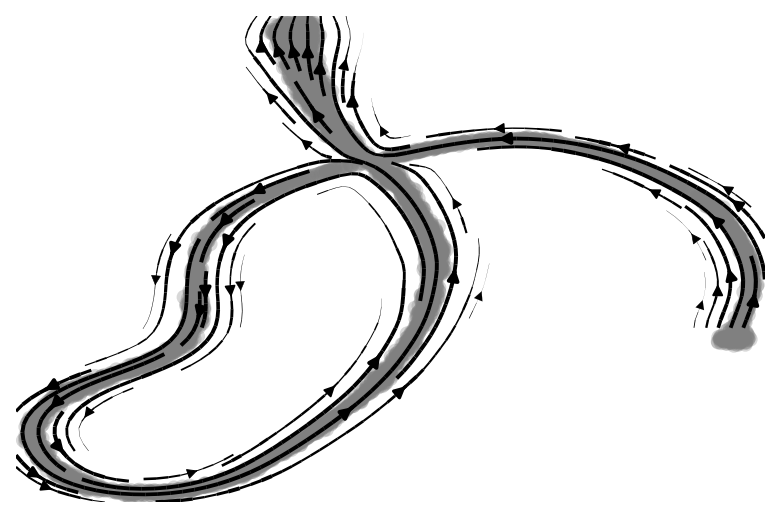

In [16]:
scv.pl.velocity_embedding_stream(adata2, basis='umap')

In [17]:
correlation_df

,correlation,method,n_obs,run
0,0.775473,Steady-state,5000,1
1,0.951958,EM,5000,1
